In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import importlib.util
import itertools

spec = importlib.util.spec_from_file_location("util", f"{os.getcwd()}/util.py")
util = importlib.util.module_from_spec(spec)
spec.loader.exec_module(util)

In [16]:
person = 'Kai'
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)
# merged_data = util.read_auto_sleep_data(person)
data = util.read_autosleep_data(person)
suppl = util.read_form_data(person)

merged_data = pd.merge(suppl, data, on='date', how='inner').fillna(0)

/home/yahiko/code/cs158/grogginess-prediction/util.py:32: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['ISO8601'], errors='coerce')


In [17]:
results = []

for L in range(1, len(util.features)+1):
  for subset in itertools.combinations(util.features, L):
    featureset = list(subset)
    X = merged_data[featureset]
    y = merged_data[util.target]

    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to tensors and create data loaders
    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # Initialize model
    model = util.GrogginessModel(input_size=len(featureset), hidden_size=64, output_size=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Train the model
    util.train_model(model, train_loader, val_loader)

    # Evaluate the model
    accuracy = util.evaluate_model(model, val_loader, criterion)  # You need to implement this function

    # Store the results
    results.append({'Features': ', '.join(featureset), 'Accuracy': accuracy})

# Sort the results by Accuracy
results_df = pd.DataFrame(results)

# Sort the results by Accuracy
results_df.sort_values(by=['Accuracy'], ascending=False, inplace=True)

# Display the top N results
print(results_df.head(10))

KeyboardInterrupt: 

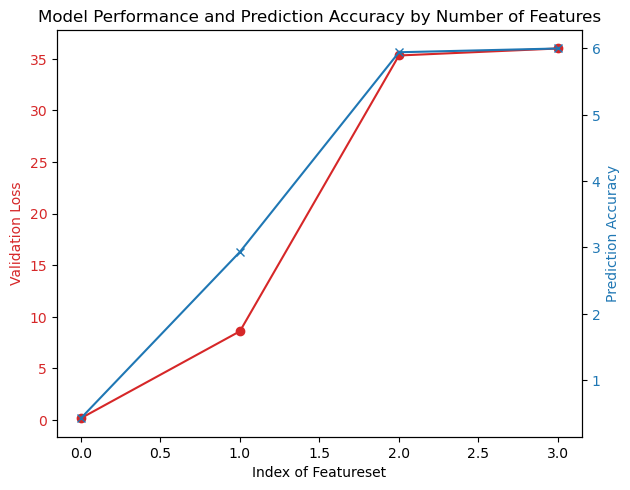

In [ ]:
fig, ax1 = plt.subplots()

# Set the color for the first y-axis
color = 'tab:red'
ax1.set_xlabel('Index of Featureset')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(features, losses, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Prediction Accuracy', color=color)
ax2.plot(features, accuracies, marker='x', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ensure layout is tight so there's no overlap
fig.tight_layout()

plt.title('Model Performance and Prediction Accuracy by Number of Features')
plt.show()